In [1]:
# load libraries and scripts
using PyPlot
using PyCall
using LaTeXStrings
using FFTW
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");

In [2]:
# load borders
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [3]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-6);

  5.283518 seconds (3.73 M allocations: 16.981 GiB, 10.38% gc time, 1.12% compilation time)
  3.480228 seconds (4.26 M allocations: 1.249 GiB, 8.45% gc time, 61.61% compilation time)


In [4]:
# get stable solution
compute_stable_sol!(contmod, interval = 10000, Niter = 250000, tol = 1e-7);
dm = load_discrete_model("../data/disc/pantagruel.h5", scale_factor);
th_disc = get_discrete_values(contmod.coord[contmod.isgrid,:], dm.coord, contmod.th[contmod.isgrid]);

[10000.0 7.328706000730989e-5]
[20000.0 2.2965377292072375e-5]
[30000.0 8.507224656173484e-6]
[40000.0 5.117974986812435e-6]
[50000.0 3.4486767581665134e-6]
[60000.0 2.454400231832743e-6]
[70000.0 1.8231819838288033e-6]
[80000.0 1.4207368513874385e-6]
[90000.0 1.1641277833929209e-6]
[100000.0 1.0006691579800275e-6]
[110000.0 8.96654425819321e-7]
[120000.0 8.305195359215034e-7]
[130000.0 7.884933592716692e-7]
[140000.0 7.617974209228606e-7]
[150000.0 7.448437090440407e-7]
[160000.0 7.340786244425246e-7]
[170000.0 7.272437861916003e-7]
[180000.0 7.229045518863941e-7]
[190000.0 7.201498040121379e-7]
[200000.0 7.184010016869635e-7]
[210000.0 7.172908212949025e-7]
[220000.0 7.165860586022532e-7]
[230000.0 7.161386658127711e-7]
[240000.0 7.158546544427935e-7]
[250000.0 7.156743613290217e-7]
 38.034913 seconds (4.22 M allocations: 81.788 GiB, 8.24% gc time, 2.13% compilation time)


In [5]:
# Second model for fourier filtering
contmod2 = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-7);

  3.330180 seconds (529.80 k allocations: 16.811 GiB, 5.25% gc time)
  1.130169 seconds (3.87 k allocations: 1.011 GiB, 1.87% gc time)


In [6]:
# Get frequencies
freq = zeros(contmod2.Ny, contmod2.Nx)
freqx = fftfreq(contmod2.Nx, dx)
freqy = fftfreq(contmod2.Ny, dx)
for i=1:contmod2.Ny
    for j=1:contmod2.Nx
        freq[i, j] = sqrt(freqy[i]^2 + freqx[j]^2)
    end
end

In [7]:
# Create filter mask
filter = freq .<= .2 * maximum(freq);

In [8]:
# Filter m
mfft = fft(reshape(contmod2.m, contmod2.Ny, contmod2.Nx))
mfft[.!filter] .= 0.0
mifft = real.(ifft(mfft))
mifft[.!contmod2.isgrid] .= 0.0
contmod2.m = vec(mifft);

In [9]:
# Filter d
dfft = fft(reshape(contmod2.d, contmod2.Ny, contmod2.Nx))
dfft[.!filter] .= 0.0
difft = real.(ifft(dfft))
difft[.!contmod2.isgrid] .= 0.0
contmod2.d = vec(difft);

In [10]:
# Filter bx
bxfft = fft(reshape(contmod2.bx, contmod2.Ny, contmod2.Nx))
bxfft[.!filter] .= 0.0
bxifft = real.(ifft(bxfft))
bxifft[.!contmod2.isgrid] .= 0.0
contmod2.bx = vec(bxifft);

In [11]:
# Filter by
byfft = fft(reshape(contmod2.by, contmod2.Ny, contmod2.Nx))
byfft[.!filter] .= 0.0
byifft = real.(ifft(byfft))
byifft[.!contmod2.isgrid] .= 0.0
contmod2.by = vec(byifft);

In [12]:
# Filter p
ptemp = zeros(contmod2.Ny * contmod2.Nx)
ptemp[contmod2.isgrid] = contmod2.p
pfft = fft(reshape(ptemp, contmod2.Ny, contmod2.Nx))
pfft[.!filter] .= 0.0
pifft = real.(ifft(pfft))
pifft[.!contmod2.isgrid] .= 0.0
ptemp2 = vec(pifft)[contmod2.isgrid]
ptemp2 .-= sum(ptemp2) / sum(contmod2.isgrid)
contmod2.p = ptemp2;

In [13]:
# get stable solution for filtered model
compute_stable_sol!(contmod2, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 9.047133777118077e-5]
[20000.0 3.071786739727855e-5]
[30000.0 1.5777491027657575e-5]
[40000.0 1.0232058610615269e-5]
[50000.0 6.854149758872552e-6]
[60000.0 4.650271239414749e-6]
[70000.0 3.2229317832310755e-6]
[80000.0 2.303863665176209e-6]
[90000.0 1.7144565978011173e-6]
[100000.0 1.3374646339325835e-6]
[110000.0 1.096742154205188e-6]
[120000.0 9.431941945248212e-7]
[130000.0 8.453152209320081e-7]
[140000.0 7.829471815323785e-7]
[150000.0 7.432161701625972e-7]
[160000.0 7.179095962150939e-7]
[170000.0 7.017920675700395e-7]
[180000.0 6.915275112540087e-7]
[190000.0 6.849906721839716e-7]
[200000.0 6.808278572023596e-7]
[210000.0 6.781769110730806e-7]
[220000.0 6.76488757456184e-7]
[230000.0 6.754137271691718e-7]
[240000.0 6.747291396713706e-7]
[250000.0 6.742931901726479e-7]
 32.920812 seconds (2.26 M allocations: 81.680 GiB, 6.35% gc time)


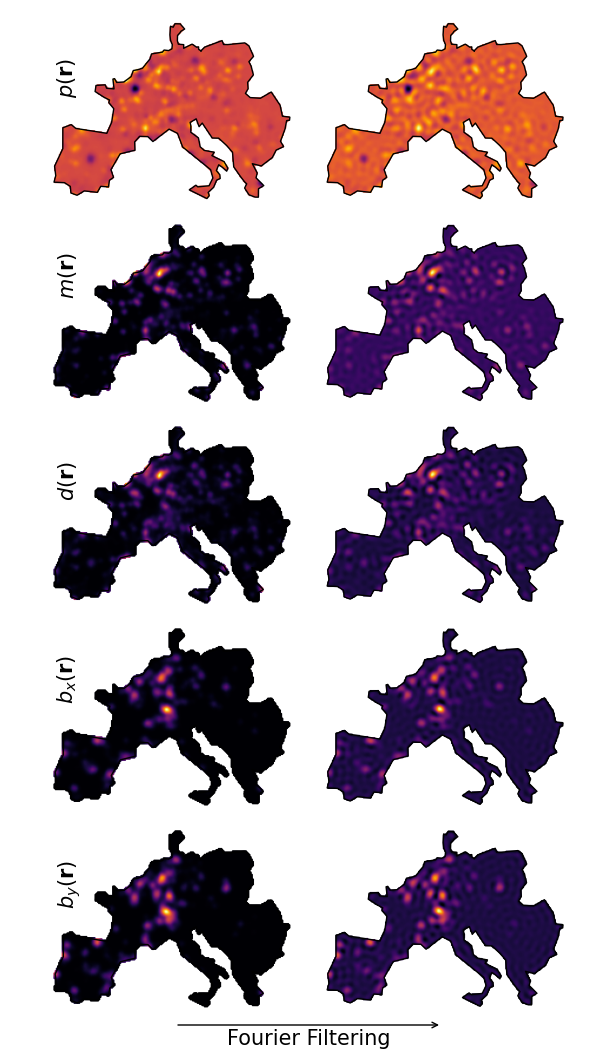

In [15]:
CMAP = :inferno
msize = 0.5
fig = plt.figure(figsize=(8*2/3,10))
gs = fig.add_gridspec(5,2)
# Turn off axis lines and ticks of the big subplot
wholefig = fig.add_subplot(py"$(gs)[:,:]")
wholefig.spines["top"].set_visible(false)
wholefig.spines["right"].set_visible(false)
wholefig.spines["bottom"].set_visible(false)
wholefig.spines["left"].set_visible(false)
wholefig.tick_params(labelcolor="white", top=false, bottom=false, left=false, right=false)
p11 = fig.add_subplot(gs[1,1])
p11.scatter(contmod.coord[contmod.isinside,2], contmod.coord[contmod.isinside,1], c=contmod.p[contmod.isinside[contmod.isgrid]], s=msize, cmap=CMAP)
p11.text(0.05, 0.6, "\$p(\\mathbf{r})\$", transform=p11.transAxes, rotation=90, fontsize=15)
p11.plot(border[:,1], border[:,2], "k", lw=1)
p11.set_aspect("equal")
p11.axis("off")
p12 = fig.add_subplot(gs[2,1])
p12.scatter(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1], c=contmod.m[contmod.isgrid], s=msize, cmap=CMAP)
p12.text(0.05, 0.6, "\$m(\\mathbf{r})\$", transform=p12.transAxes, rotation=90, fontsize=15)
p12.plot(border[:,1], border[:,2], "k", lw=1)
p12.set_aspect("equal")
p12.axis("off")
p13 = fig.add_subplot(gs[3,1])
p13.scatter(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1], c=contmod.d[contmod.isgrid], s=msize, cmap=CMAP)
p13.text(0.05, 0.6, "\$d(\\mathbf{r})\$", transform=p13.transAxes, rotation=90, fontsize=15)
p13.plot(border[:,1], border[:,2], "k", lw=1)
p13.set_aspect("equal")
p13.axis("off")
p14 = fig.add_subplot(gs[4,1])
p14.scatter(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1], c=contmod.bx[contmod.isgrid], s=msize, cmap=CMAP)
p14.text(0.05, 0.6, "\$b_x(\\mathbf{r})\$", transform=p14.transAxes, rotation=90, fontsize=15)
p14.plot(border[:,1], border[:,2], "k", lw=1)
p14.set_aspect("equal")
p14.axis("off")
p15 = fig.add_subplot(gs[5,1])
p15.scatter(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1], c=contmod.by[contmod.isgrid], s=msize, cmap=CMAP)
p15.text(0.05, 0.6, "\$b_y(\\mathbf{r})\$", transform=p15.transAxes, rotation=90, fontsize=15)
p15.plot(border[:,1], border[:,2], "k", lw=1)
p15.set_aspect("equal")
p15.axis("off")
p21 = fig.add_subplot(gs[1,2])
p21.scatter(contmod2.coord[contmod2.isinside,2], contmod2.coord[contmod2.isinside,1], c=contmod2.p[contmod2.isinside[contmod2.isgrid]], s=msize, cmap=CMAP)
p21.plot(border[:,1], border[:,2], "k", lw=1)
p21.set_aspect("equal")
p21.axis("off")
p22 = fig.add_subplot(gs[2,2])
p22.scatter(contmod2.coord[contmod2.isinside,2], contmod2.coord[contmod2.isinside,1], c=contmod2.m[contmod2.isinside], s=msize, cmap=CMAP)
p22.plot(border[:,1], border[:,2], "k", lw=1)
p22.set_aspect("equal")
p22.axis("off")
p23 = fig.add_subplot(gs[3,2])
p23.scatter(contmod2.coord[contmod2.isinside,2], contmod2.coord[contmod2.isinside,1], c=contmod2.d[contmod2.isinside], s=msize, cmap=CMAP)
p23.plot(border[:,1], border[:,2], "k", lw=1)
p23.set_aspect("equal")
p23.axis("off")
p24 = fig.add_subplot(gs[4,2])
p24.scatter(contmod2.coord[contmod2.isinside,2], contmod2.coord[contmod2.isinside,1], c=contmod2.bx[contmod2.isinside], s=msize, cmap=CMAP)
p24.plot(border[:,1], border[:,2], "k", lw=1)
p24.set_aspect("equal")
p24.axis("off")
p25 = fig.add_subplot(gs[5,2])
p25.scatter(contmod2.coord[contmod2.isinside,2], contmod2.coord[contmod2.isinside,1], c=contmod2.by[contmod2.isinside], s=msize, cmap=CMAP)
p25.plot(border[:,1], border[:,2], "k", lw=1)
p25.set_aspect("equal")
p25.axis("off")
wholefig.annotate("", xy=(0.75, -0.01), xycoords="axes fraction", xytext=(0.25, -0.01),
            arrowprops=Dict([("arrowstyle","->"), ("color","k")]))
wholefig.text(0.5, -0.03, "Fourier Filtering", transform=wholefig.transAxes, fontsize=15, ha="center")
plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0, wspace=0.05, hspace=0.05)
# fig.tight_layout()
fig.savefig("../figures/param_fourier.svg", bbox_inches="tight")


In [15]:
msize = 2
clim = extrema([contmod.th; contmod2.th])
fig, axs = plt.subplots(1,3, figsize=(8,2.5), gridspec_kw=py"{\"width_ratios\":[1,1,0.05]}")
axs[1].scatter(contmod.coord[contmod.isinside,2], contmod.coord[contmod.isinside,1], c=contmod.th[contmod.isinside], s=msize, cmap=CMAP, vmin=clim[1], vmax=clim[2])
axs[2].scatter(contmod2.coord[contmod2.isinside,2], contmod2.coord[contmod2.isinside,1], c=contmod2.th[contmod2.isinside], s=msize, cmap=CMAP, vmin=clim[1], vmax=clim[2])
axs[1].set_aspect("equal")
axs[2].set_aspect("equal")
axs[1].axis("off")
axs[2].axis("off")
axs[1].text(0.1, 0.9, "(a)", transform=axs[1].transAxes)
axs[2].text(0.1, 0.9, "(b)", transform=axs[2].transAxes)
fig.colorbar(axs[2].collections[1], cax=axs[3])
plt.subplots_adjust(left=0.0, right=0.9, top=1.0, bottom=0.0, wspace=0.05, hspace=0.05)
plt.savefig("../figures/thetas_fourier.pdf")

LoadError: UndefVarError: contmod not defined